<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Diplomado de Análisis de datos y Machine Learning en Python</h1>


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

<p><a name="contents"></a></p>

# Contenido Sesión 11

- <a href="#Density">1. Estimador de densidad (KDE).</a><br>
- <a href="#PCA">2. Análisis de componentes principales (PCA).</a><br>
- <a href="#Repaso">3. Resumen </a><br>

# 1. Estimador de densidad (KDE)

Un estimador de densidad es un algoritmo que busca modelar la distribución de probabilidad que generó un conjunto de datos. Un ejemplo de esto es el histograma: Cuando usamos histogramas utilizamos alguna forma de estimación de densidad. Es decir, aunque solo tenemos unos pocos puntos de datos discretos, realmente pretendemos que tenemos algún tipo de distribución continua, y nos gustaría saber cuál es esa distribución. 

Uno de los problemas con el uso de un histograma como estimador de densidad es que la elección del tamaño y ubicación de los bines puede conducir a representaciones que tienen características cualitativamente diferentes. En la siguiente figura se muestran dos histogramas diferentes para el mismo conjunto de datos: 

<p><img alt="Colaboratory logo" height="200px" src="https://i.imgur.com/XYrUsRT.png" align="left" hspace="10px" vspace="0px"></p>

A la izquierda, vemos una distribución bimodal. A la derecha, vemos una distribución unimodal con una cola larga. Probablemente no adivinaríamos que estos dos histogramas se crearon a partir de los mismos datos. Podemos pensar en un histograma como una pila de bloques, donde apilamos un bloque dentro de cada bin en la parte superior de cada punto del conjunto de datos:

<p><img alt="Colaboratory logo" height="250px" src="https://i.imgur.com/qcONTFT.png" align="left" hspace="10px" vspace="0px"></p>

El problema con este tipo de bineado se debe al hecho de que la altura de la pila de bloques a menudo no se refleja en la densidad real de los puntos cercanos, sino en las coincidencias de cómo se alinean los bins con los puntos de datos.

Pero, ¿qué pasa si, en lugar de apilar los bloques alineados con los bines, apilamos los bloques alineados con los puntos que representan? 

<p><img alt="Colaboratory logo" height="250px" src="https://i.imgur.com/cZTVtlQ.png" align="left" hspace="10px" vspace="0px"></p>

El resultado parece un poco desordenado, pero es un reflejo mucho más sólido de las características de los datos reales que el histograma estándar. Aún así, los bordes no son estéticamente agradables, ni reflejan ninguna propiedad verdadera de los datos. Para suavizarlos, podríamos decidir reemplazar los bloques en cada ubicación con una función suave, por ejemplo con una gaussiana:

<p><img alt="Colaboratory logo" height="250px" src="https://i.imgur.com/oWdQPJI.png" align="left" hspace="10px" vspace="0px"></p>



Esta gráfica suavizada, da una idea mucho más precisa de la forma de la distribución de los datos. 

## 1.1. KDE en la práctica

Las dos últimas gráficas son ejemplos de KDE en una dimensión. La idea básica aquí es ubicar una distribución (kernel) $K$ sobre cada punto 

<p><img alt="Colaboratory logo" height="200px" src="https://i.imgur.com/isgKTAG.png" align="left" hspace="10px" vspace="0px"></p>

y sumar cada contribución para obtener una distribución de probabilidad $$f(x)=\frac{1}{N \cdot h}\displaystyle\sum_{i=1}^{N} k\left(\frac{x-x_i}{h}\right)$$

<p><img alt="Colaboratory logo" height="200px" src="https://i.imgur.com/iggiUXV.png" align="left" hspace="10px" vspace="0px"></p>

Los parámetros libres del KDE son el *kernel* $k$, que especifica la forma de la distribución ubicada en cada punto, y el *ancho de banda* $h$ del kernel, que controla el tamaño del kernel en cada punto. La implementación del KDE mediante sklearn se hace a través del módulo `sklearn.neighbors` como `KernelDensity`:

In [ ]:
# creamos una función para generar datos
import numpy as np

def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5 # x = x+5
    return x

x = make_data(1000)

In [ ]:
x

In [ ]:
type(x)

numpy.ndarray

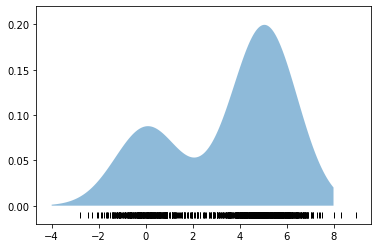

In [ ]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

x_d = np.linspace(-4, 8, 2000)

# instanciamos y entrenamos el modelo
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples devuelve el logaritmo de la densidad de probabilidad
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

## 1.2. Ancho de banda

La selección del ancho de banda es una pieza importante del KDE: es el hiperparámetro que controla la compensación de sesgo-varianza en la estimación de la función de densidad: un ancho de banda demasiado estrecho conduce a una estimación de alta varianza (sobreajuste) donde la presencia o ausencia de un solo punto hace una gran diferencia
. Un ancho de banda demasiado ancho conduce a una estimación de alto sesgo (subajuste) donde la estructura de los datos es eliminada por el ancho del kernel

In [ ]:
from scipy.stats.distributions import norm

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


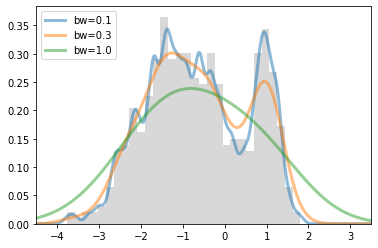

In [ ]:


# Obteniendo puntos de una distribución bimodal en 1D
np.random.seed(0)
x_grid = np.linspace(-4.5, 3.5, 1000)

x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left');

Usar diferentes anchos de banda puede conducir a ideas completamente diferentes de la naturaleza subyacente de los datos. Dada la importancia del ancho de banda, ¿cómo podríamos determinar el ancho de banda óptimo para un problema determinado? En el contexto del ML, hemos visto que tal ajuste de hiperparámetros a menudo se realiza empíricamente mediante validación cruzada. Usaremos GridSearchCV para optimizar el ancho de banda para el conjunto de datos anterior:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# valores para evaluar el ancho de banda
grid_param = {'bandwidth': np.linspace(0.1, 1.0, 30)}

grid = GridSearchCV(KernelDensity(kernel='gaussian'), grid_param, cv=20)

grid.fit(x[:, None])

grid.best_params_

{'bandwidth': 0.19310344827586207}

Según el puntaje de validación cruzada (es decir, la probabilidad máxima), el mejor ancho de banda es de alrededor de 0.19:

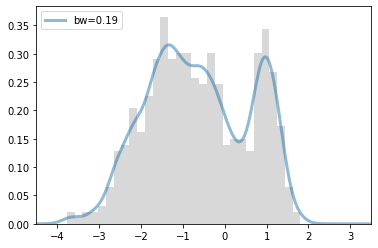

In [ ]:
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-4.5, 3.5);

Vemos que la validación cruzada produce un ancho de banda que está cerca de lo que podríamos elegir a simple vista, y la estimación de densidad resultante refleja estrechamente la distribución de los datos subyacentes.

## 1.3. Kernels

Hemos estado usando el kernel gaussiano, pero esta no es la única opción disponible. KDE se puede usar con cualquier función de [kernel](https://scikit-learn.org/stable/modules/density.html), y diferentes kernels conducen a estimaciones de densidad con diferentes características. Realicemos una visualización rápida de los seis kernels disponibles en Scikit-learn:

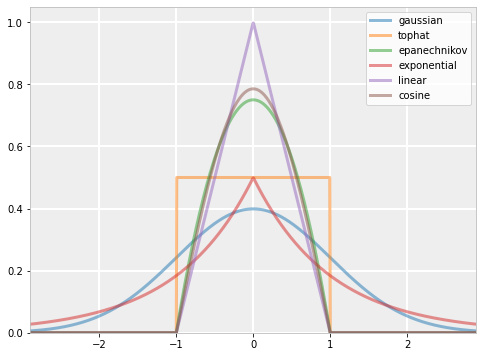

In [ ]:
def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()
    
plot_kernels()

## 1.4. Dependencia del Kernel

Para puntos lejanos, algunos kernels tienen pesos mucho más cercanos a cero que otros: en el caso de los kernels con límites "fuertes" (como el kernel tophat), los puntos distantes contribuyen exactamente con cero a la densidad. 

En el extremo opuesto, para los puntos que están muy cerca en comparación con el tamaño del kernel, los kernels que son muy "planos" (por ejemplo, kernel tophat) permitirán considerar grupos enteros de puntos a la vez, mientras que los núcleos que son menos planos (por ejemplo, el kernel lineal o exponencial) no admitirá tales eficiencias.

Podemos ver este comportamiento en la siguiente figura:

<p><img alt="Colaboratory logo" height="350px" src="https://i.imgur.com/wiH8jsx.png" align="left" hspace="10px" vspace="0px"></p>

Observe las dos regiones de interés: para anchos de banda muy pequeños, los kernels con un corte fuerte (tophat, lineal) superan a los kernels con un cono amplio (gaussiano, exponencial). Y los kernels cónicos que caen más rápidamente (gaussiano) se calculan de manera más eficiente que los kernels que caen más lentamente (exponencial).

En el otro extremo, los kernels con perfiles muy planos cerca de cero (tophat, gaussiano) muestran una mejora para anchos de banda grandes, mientras que los kernels con perfiles muy empinados cerca de cero (lineal, exponencial) no muestran ninguna mejora

<p><a name="PCA"></a></p>

# 2. Análisis de Componentes Principales (PCA)

[[Contenidos]](#contents)

PCA es un método que consiste en rotar el dataset de tal forma que las componentes rotadas son estadisticamente no-correlacionadas. Si se desea también reducir la dimensionalidad, esta rotación es seguida de una selección de un subconjunto de características de acuerdo con su importancia.

## 2.1. Intuición inicial
Tenemos los siguientes datos 2D y nos gustaría encontrar una proyección en 1D que preserve la máxima cantidad de variabilidad.

In [ ]:
!pip install mglearn
import mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 540 kB 29.5 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=225a567fcf35555169368dc408763983392003e10a8ccb0f0f4b560f78ebbd80
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


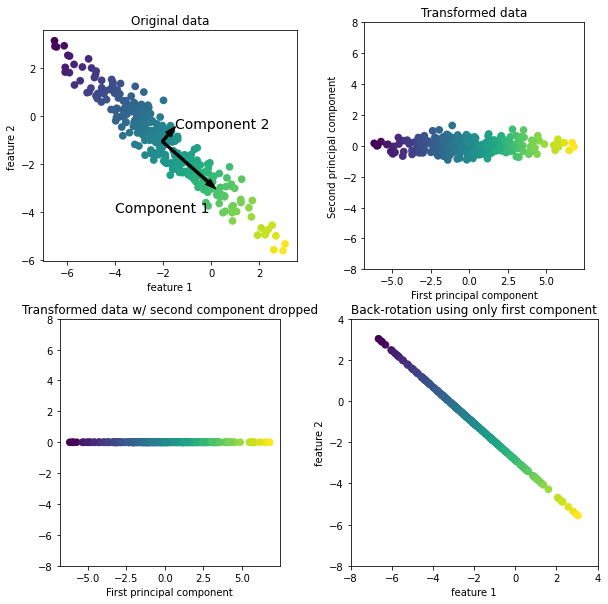

In [ ]:
mglearn.plots.plot_pca_illustration()

## 2.2. Intuición práctica

(200, 2)


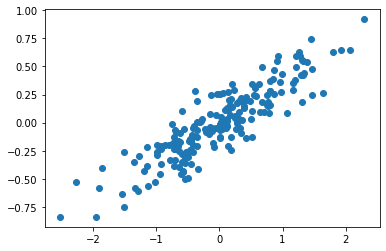

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T+10

X = X-np.mean(X, axis=0)
print (X.shape)
plt.scatter(X[:,0], X[:,1]);

Inspeccionamos algunas proyecciones

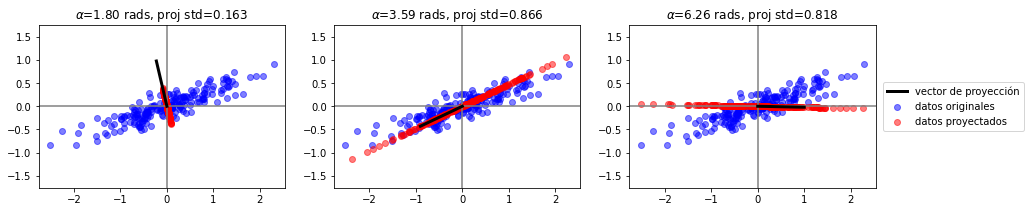

In [ ]:
plt.figure(figsize=(15,3))

unit_vector = lambda angle: np.array([np.cos(angle), np.sin(angle)])

for i in range(3):
    plt.subplot(1,3,i+1)
    angle = np.random.random()*np.pi*2 if i!=0 else 1.8
    v = unit_vector(angle)

    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
    Xp = np.repeat(v.reshape(-1,2),len(X),axis=0)*c

    plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="datos originales")
    plt.scatter(Xp[:,0], Xp[:,1], color="red", alpha=.5, label="datos proyectados")
    plt.axvline(0, color="gray")
    plt.axhline(0, color="gray")
    plt.plot([0,v[0]], [0,v[1]], color="black", lw=3, label="vector de proyección")
    plt.axis('equal')
    plt.ylim(-2,2)
    plt.title("$\\alpha$=%.2f rads, proj std=%.3f"%(angle, np.std(c)))
    if i==2:
        plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

Implementemos PCA y veamos los resultados que obtenemos para dos y una componente.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2) 
pca.fit(X)
print("Componentes")
print(pca.components_)
print("Norma de las componentes")
print(pca.explained_variance_)

Componentes
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
Norma de las componentes
[0.7625315 0.0184779]


In [ ]:
pca = PCA(n_components=1) 
pca.fit(X)
print("Componentes")
print(pca.components_)
print("Norma de las componentes")
print(pca.explained_variance_)

Componentes
[[-0.94446029 -0.32862557]]
Norma de las componentes
[0.7625315]


Las componentes principales corresponden a las direcciones en los datos originales, por lo tanto son combinaciones de las características originales. Cada fila en `components_` corresponde a una componente principal y se organizan dependiendo de su importancia. Asímismo, cada columna corresponde a cada una de las caraterísticas originales. Las entradas de `explained_variance_` corresponden a la norma de los vectores de las componentes principales, los cuales indican que tan "importante" es el respectivo eje en la descripción de la distribución de los datos. 


Veamos ahora como quedan nuestros datos transformados.

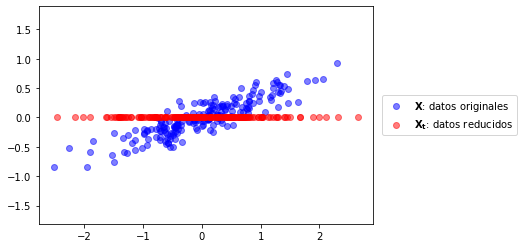

In [ ]:
Xt = pca.transform(X)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="$\mathbf{X}$: datos originales")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: datos reducidos")
plt.axis("equal");
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5));

y podemos también reconstruir los datos 2D después de la transformación

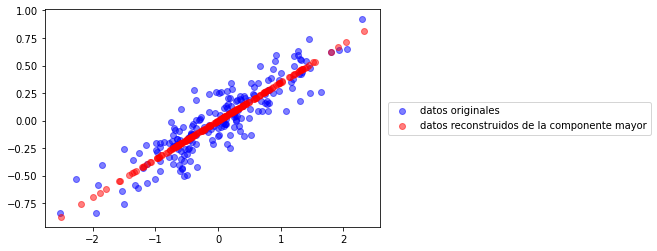

In [ ]:
Xr = pca.inverse_transform(Xt)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="datos originales")
plt.scatter(Xr[:,0], Xr[:,1], color="red", alpha=.5, label="datos reconstruidos de la componente mayor")
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5));

## 2.3. Usando PCA para visualizar datos multidimensionales

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import PCA

In [ ]:
# cargamos los datos y los estandarizamos
cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [ ]:
len(cancer.feature_names)

30

In [ ]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
# aplicamos PCA con dos componentes principales
pca = PCA(n_components=2)

pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Forma original: {}".format(str(X_scaled.shape)))
print("Forma reducida: {}".format(str(X_pca.shape)))

Forma original: (569, 30)
Forma reducida: (569, 2)


Text(0, 0.5, 'PCA2')

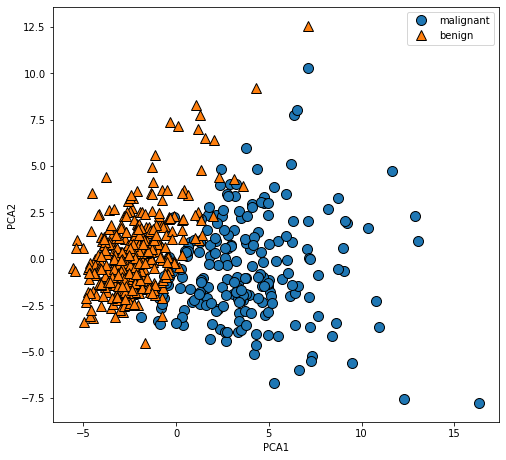

In [ ]:
# graficamos en el espacio de las componentes
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

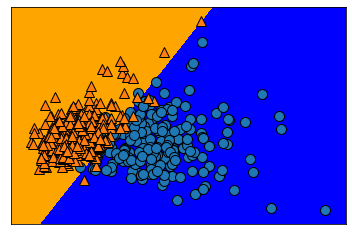

In [ ]:
# entrenamos un regresor LG
clf = LogisticRegression(solver="liblinear")
clf.fit(X_pca,cancer.target)

mglearn.plots.plot_2d_classification(clf,X_pca,fill=True, cm=ListedColormap(['blue','orange']))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.show();

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_pca,cancer.target,
                                                  test_size=0.2,random_state=10)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        39
           1       0.96      0.97      0.97        75

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

[[36  3]
 [ 2 73]]


Veamos ahora los resultados de la clasificación si no hubiesemos hecho la reducción de dimensionalidad con PCA.

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled,cancer.target,
                                                  test_size=0.2,random_state=10)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print (classification_report(y_test,y_pred))
print (confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.97      0.97      0.97        75

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

[[37  2]
 [ 2 73]]


Vemos que en ambos casos obtenemos resultados muy similares. Para tener una mejor visualización del número estimado de componentes que se necesitan para describir los datos, podemos utilizar lo que se conoce como razón de la varianza acumulativa en función del número de componentes:

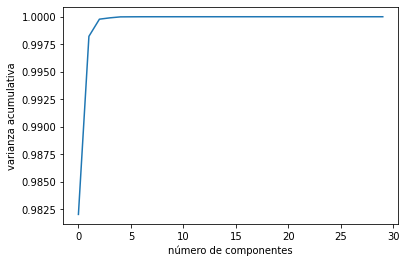

In [ ]:
pca = PCA().fit(cancer.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('varianza acumulativa');

La curva cuantifica cuánto de la varianza total está contenida en las primeras N componentes. Observamos que, en este caso, las dos primeras componentes contienen alrededor del 99% de la varianza, y se necesitan alrededor de tres componentes para describir cerca del 100% de la varianza. 

Aternativamente, el hiperparámetro `n_components` puede ser usado en el rango (0,1), con lo cual se indica al modelo que contenga un cierto porcentaje de la varianza, y el modelo nos devolverá el número de componentes necesarias para tener ese porcentaje de varianza:  

In [ ]:
# reteniendo el 50 % de la varianza
pca = PCA(n_components=0.5).fit(cancer.data)

print("Número de componentes: ",pca.n_components_)

Número de componentes:  1


Podemos concluir entonces que para este dataset, haber tomado solo dos componentes principales permite visualizar que la separación de los datos es lineal sin perder calidad en los resultados.

## 2.4. Usando KDE y PCA 

Este ejemplo muestra cómo el KDE puede usarse para aprender un modelo generativo para un conjunto de datos. Con este modelo generativo se pueden extraer nuevas muestras. Lo implementaremos en el ya conocido dataset de dígitos:



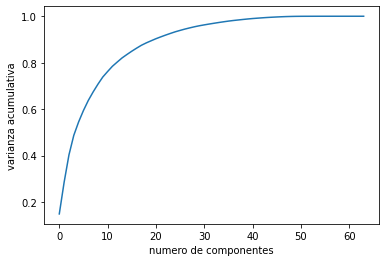

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# cargamos los datos
digits = load_digits()

# veamos la razón de la varianza acumulativa
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('varianza acumulativa');

In [ ]:
len(digits.data[0])

64

Ancho de banda óptimo: 3.79269019073225


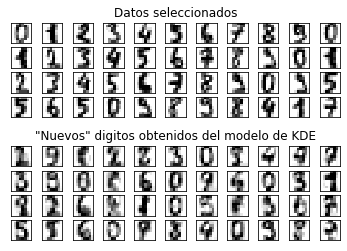

In [ ]:
# proyectamos los datos (64 dimensiones) a una dimension menor (15)
pca = PCA(n_components=15)
data = pca.fit_transform(digits.data)

# usamos gridsearch para obtener el valor optimo del ancho de banda
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(data)

print("Ancho de banda óptimo: {0}".format(grid.best_estimator_.bandwidth))

# usamos el mejor estimador para el KDE
kde = grid.best_estimator_

# tomamos 44 nuevos puntos de los datos
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# convertimos los datos a una grilla de 4x11
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# graficamos los digitos reales y los digitos remuestreados
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Datos seleccionados')
ax[5, 5].set_title('"Nuevos" digitos obtenidos del modelo de KDE')

plt.show()

# 3. Resumen:


## 3.1. Regresiones:

Para los siguientes modelos, usaremos un dataset real de viviendas en Boston. El objetivo con este dataset consiste en predecir el valor medio de los precios de las casas en diferentes barrios de Boston en los 70s, mediante información como la tasa de asesinatos, proximidad al rio Charles, accesibilidad a las autopistas, etc. 

In [ ]:
from sklearn.model_selection import train_test_split

# load_extended_boston
X, y = mglearn.datasets.load_extended_boston()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print("Data shape: {}".format(X.shape))

print(type(X))
print(X.shape)

Data shape: (506, 104)
<class 'numpy.ndarray'>
(506, 104)


El dataset load_boston_extended consta de 506 instancias y 104 caracterísiticas.

Ajuste de un conjunto de características o variables a un hiperplano:

$$y=\sum_{i=0}^n w_ix_i$$

La creación de un modelo mediante `sklearn` se realiza mediante el módulo `linear_model` **clase** `LinearRegression`. Por otra parte, el ajuste se realiza mediante el **método** `fit()`, el cual recibe como argumentos los datos de características $X$ y variable objetivo $y$.

A continuación, repasaremos brevemente, cada una de las regresiones estudiadas a lo largo del curso, haciendo hincapié en la noción de objeto, clase, instancia e hiperparámetros del modelo:

In [ ]:
# Multiple Linear Regression.
# Importar clase LinearRegression del módulo linear_model de sklearn.
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.95
Test set score: 0.61


### Regresión Ridge

La penalización se hace mediante el hiper parámetro $\alpha$:

$$\sum (Y_i-\hat Y_i)^2+\alpha \sum w_i^2 $$


Haciendo que sean más pequeños los coeficientes y estabilizando las soluciones aunque a costa de una menor sensibilidad a los datos.

In [ ]:
# Ridge
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.89
Test set score: 0.75


Score de entrenamiento más bajo que la regresión lineal, pero score de evaluación más alto: Con la regresión lineal creamos un modélo más **sobreajustado**. Con la regresión `Ridge` buscamos modelos más generales a costa de empeorar el redimiento en el grupo de entrenamiento. 

**Conclusión:** El modelo `Ridge` implica un compromiso entre la simplicidad del modelo y el desempeño dentro del conjunto de entrenamiento.

El aumento del hiperparámetro $\alpha$ fuerza a los coeficientes a ser cero, lo que puede empeorar el desempeño del ajuste en los datos de entrenamiento pero mejorar en los de evaluación.


In [ ]:
# Ridge Alpha 10
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

Training set score: 0.79
Test set score: 0.64


In [ ]:
#Ridge alpha 0.1
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.93
Test set score: 0.77


Al decrecer el hiperparámetro $\alpha$, creamos un modelo menos restrictivo (mejor desempeño en el grúpo de entrenamiento). Comparemos los diferentes valores del hiperparámetro $\alpha$, con el fin de ver su efecto en el ajuste, como lo hemos advertido:

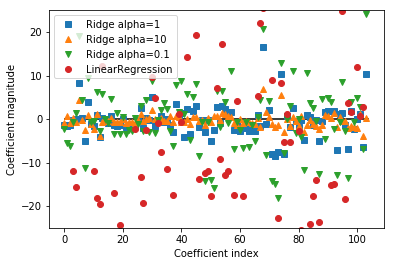

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(lr.coef_, 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend();

### Regresión Lasso

Realiza una regularización $L_1$, forzando a que algunos coeficientes sean exactamente cero.

$$\sum (Y_i-\hat Y_i)^2+\alpha \sum |w_i|$$

Lo anterior implica que algunas características sean ingnoradas completamente del modelo. Este modelo implica una forma de selección automática de características.


In [ ]:
# Lasso Default alpha=1
import numpy as np
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.29
Test set score: 0.21
Number of features used: 4


Vemos un modelo muy simple con un bajo desempeño en ambos grupos (entrenamiento y evaluación). Para evitar el subajuste, disminuimos el valor de $\alpha$.

In [ ]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))

Training set score: 0.90
Test set score: 0.77
Number of features used: 33


Vemos que el desempeño del modelo mejora. Si fijamos un valor muy bajo del hiperparámetro, eliminamos la regularización y tendemos a hacer un sobrejuste a los datos de 

In [ ]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ != 0)))

Training set score: 0.95
Test set score: 0.64
Number of features used: 96


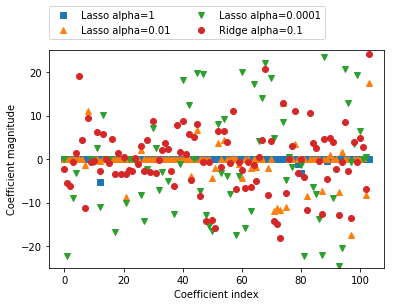

In [ ]:
plt.plot(lasso.coef_, 's', label="Lasso alpha=1")
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01")
plt.plot(lasso00001.coef_, 'v', label="Lasso alpha=0.0001")
plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-25, 25)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude");

### Redes elásticas:
A las regresiones que usan una combinación de ambas penalidades ($L_1$ y $L_2$) se les conoce como **ElasticNet** (Redes elásticas) y definimos su error como:
$$\sum (Y_i- \hat Y_i)^2+\alpha \rho \sum |w_i| + \frac{\alpha(1-\rho)}{2}\sum w_i^2. $$

Note que cuando $ \rho=1$ tenemos la regresión Lasso, y con $\rho=0$ tendremos la de Ridge, por tanto en las redes elásticas $0\leq \rho\leq1$.

In [ ]:
# Elasticnet
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.001,l1_ratio=0.999,max_iter=10000,normalize=True).fit(X_train,y_train)

print("Training set score: {:.2f}".format(elastic.score(X_train, y_train)))
print("Test set score: {:.2f}".format(elastic.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(elastic.coef_ != 0)))

Training set score: 0.93
Test set score: 0.78
Number of features used: 48


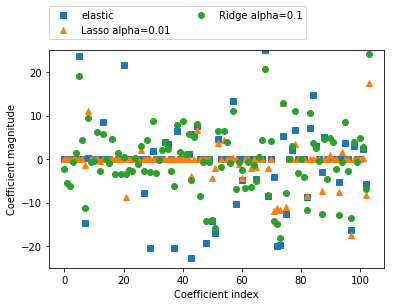

In [ ]:
plt.plot(elastic.coef_, 's', label="elastic")
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01")
plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-25, 25)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude");

### Ajuste polinómico:

A continuación realizamos un ajuste polinómico de los ingresos en función del nivel alcanzado en una empresa. 

El primer paso es realizar un preprocesado de los datos, mediante la clase `PolynomialFeatures`, del módulo `preprocessing` de `sklearn`, elevando la característica en cuestión a "características" de grado 0, 1, 2, 3 y 4. Posteriormente, realizamos el ajuste:

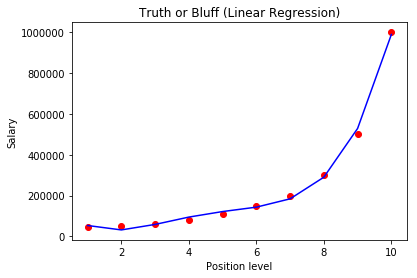

In [ ]:
# Polinomial fit

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('https://s3.us-west-2.amazonaws.com/public.gamelab.fun/dataset/position_salaries.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

plt.scatter(X, y, color='red')
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
plt.title('Truth or Bluff (Linear Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

Para realizar este ajuste, usamos el método de `curve_fit` de `optimize` de la librería de `scipy`. Definamos primero una función exponencial y posteriormente le agregamos ruido. Finalmente ajustamos nuestro modelo:

In [ ]:
# Curve fit

# definition of exponential function.
def func(x, a, b, c):
...     return a * np.exp(-b * x) + c

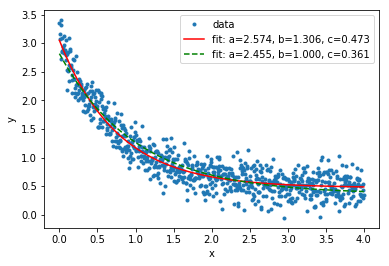

In [ ]:
# Curve fit: exponential

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

xdata = np.linspace(0, 4, 800)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(0)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

plt.plot(xdata, ydata, 'o', markersize=3, label='data')
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
plt.plot(xdata, func(xdata, *popt), 'g--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Ajuste mediante SVM o SVR:

Exportamos el módulo `svm` de `sklearn` y accedemos a la clase `SVR` para instanciar la clase (definimos un objeto). Dentro de este objeto, llamado `estimator`, accedemos al método `fit()` para realizar el ajuste:

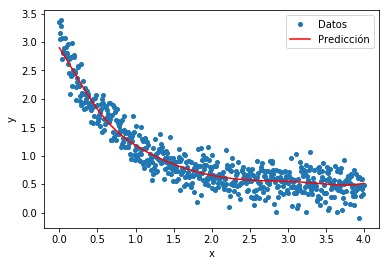

In [ ]:
# Curve fit: exponential

import sklearn.svm as svm  
from sklearn.model_selection import train_test_split

xdata = np.linspace(0, 4, 600)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(0)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
xdata = xdata.reshape(-1,1)

estimator=svm.SVR(kernel='rbf', gamma='auto')
estimator.fit(xdata, ydata)

y_pred = estimator.predict(xdata)

plt.plot(xdata,ydata,'o',markersize=4,label='Datos')
plt.plot(xdata,y_pred, '-', markersize=4,color='r', label='Predicción')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 3.2 Clasificación, Recapitulando

Recordemos el objetivo en la clasificación es predecir una clase, que corresponde a una opción entre una lista predefinida de posibilidades. El problema de clasificación puede separarse en dos categorías:

Clasificación binaria: cuyo proposito consiste en estimar si una instacia corresponde a una clase de dos posibles. La clasificación binaria puede pensarsar como el dar respuesta de si o no a una pregunta; clasificar un paciente como enfermo o sano, respecto a una enfermedad; clasificar un correo como spam o no; etc.

Clasificación multi-clase: en donde se estima si una instacia corresponde a una clase de mas de dos clases posibles. Algunos ejemplos de clasificación multi-clases en ML consiten en la clasificación de plantas de diferentes especies; clasificación para predecir el lenguaje de una determinada página Web; etc.

Recordemos que el problema de regresión consiste en la determinación de una una variable objetivo continua, mientras que en el problema de clasificación se busca poner un conjunto de etiquetas finitas a las instancias de la tabla.

Durante el curso vimos varios algorítmos para ésta tarea, también algunas metricas para medir su efectividad.

Metodologías como la medida de la precisión, el recall y el score f_1. Los cuales son de especial cuidado si tenemos datasets desequilibrados en los cuales el accuracy puede ser una metrica muy engañosa.

## 3.2.1 SVC

En SVC escogemos la recta (hiperplano) que maximiza el margen, entendiendo como el margen la distacia maxima que hay entre los puntos de las dos clases. Los puntos que están mas cerca de la frontera (línea punteada) se conocen como los vectores de soporte, estos pueden quedar sobre la línea de frontera o fuera de ella. 

![](https://camo.githubusercontent.com/cb709bb9432f3e1fc7b3ca19579d0424fbf466bc/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3330302f302a306f38784941346b33675855444346552e706e67)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# copiando el archivo mlutils.py en la carpeta local
!wget "https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso1/master/s06/mlutils.py"
import mlutils

--2019-10-05 11:18:42--  https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso1/master/s06/mlutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10691 (10K) [text/plain]
Saving to: ‘mlutils.py’

mlutils.py          100%[===================>]  10.44K  --.-KB/s    in 0s      

2019-10-05 11:18:42 (117 MB/s) - ‘mlutils.py’ saved [10691/10691]



In [ ]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split

In [ ]:
!pip install mglearn

     |████████████████████████████████| 542kB 9.2MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.7-py2.py3-none-any.whl size=582705 sha256=440c69f700541d04489f42334e82288fd0b429d7b562ed784d1970caaa8edfe8
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [ ]:
X,y = make_blobs(400, centers=2, cluster_std=1, random_state=0)
X.shape, y.shape

((400, 2), (400,))

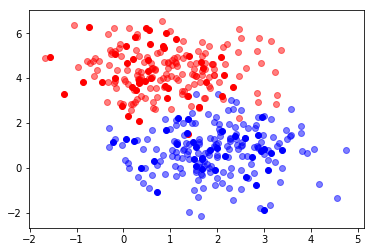

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

plt.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], color="red", alpha=0.5)
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], color="blue", alpha=0.5)

plt.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], color="red")
plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], color="blue");

number of support vectors 27


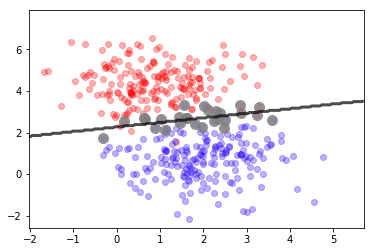

In [ ]:
from  sklearn.svm import SVC
sv = SVC(kernel='linear')
sv.fit(X_train,y_train)
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)
plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_));

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


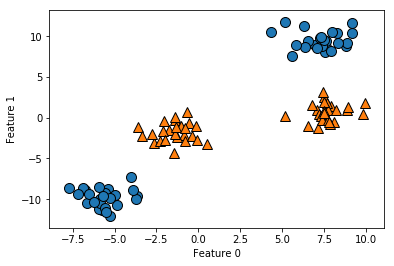

In [ ]:
import mglearn
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

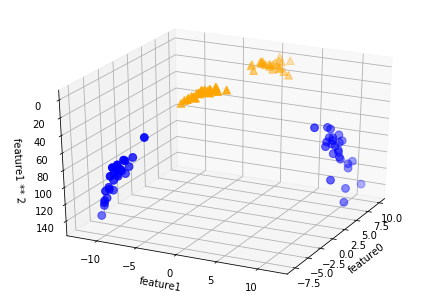

In [ ]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='orange', marker='^',
cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2");

#### Usando los kernel
Igual que para la regresión, los kernel disponibles en sklearn son lineal ('linear'), polinómico ('poly'), función de base radial ('rbf'), sigmoide('sigmoid'). El hiperparámetro $\gamma$ está asociado a los coeficientes de los kernel. Veamos por ejempĺo en el caso del kernel de base radial (RBF) $K_{rbf}=\exp(-\gamma |x_1-x_2|^2)$ la dependencia de $\gamma$ en la clasificación. En este caso lo podemos interpretar como cuanto de cercanos han de estar dos puntos para considerarlos similares.

Por tanto al aumentar $\gamma$ estaremos aumentando la complejidad del modelo y por tanto seremos más dados al overfitting.



score_train 0.996875
score_test 1.0
number of support vectors 47


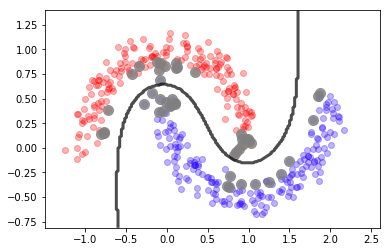

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

X,y = make_moons(400, noise=0.1, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)
sv = SVC(gamma=1)
sv.fit(X_train,y_train)
print ("score_train",sv.score(X_train,y_train))
print ("score_test",sv.score(X_test,y_test))
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)

plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_))

## 3.2.2. Regresión Logística:


Como se ha mencionado, algunos algoritmos de regresión pueden ser usados para el problema de clasificación. La Regresión Logística se usa, comunmente, para determinar la probabilidad de que una instancia pertenezca a una clase particular.

Supongamos que tenemos dos clases: clase A (clase positiva, etiquetada como 1) y clase B (clase negativa, etiquetada como 0). Si estimamos una probabilidad $\hat{p}$ en regresión logística, tenemos entonces que el problema de clasificación binario se trata de la siguiente forma:

$$\begin{equation*}
\hat{y} = \begin{cases}
1 \; {si} \; \hat{p}\geq0.5\\
0 \; {si} \; \hat{p}\lt0.5
\end{cases}
\end{equation*}$$

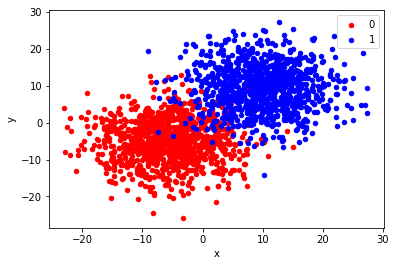

Train set: (1600, 2) (1600,)
Test set: (400, 2) (400,)


[(-22.981715497289997, 27.37181699382255),
 Text(0, 0.5, '$X_2$'),
 (-25.814445291719665, 27.365133706091257),
 Text(0.5, 0, '$X_1$'),
 None]

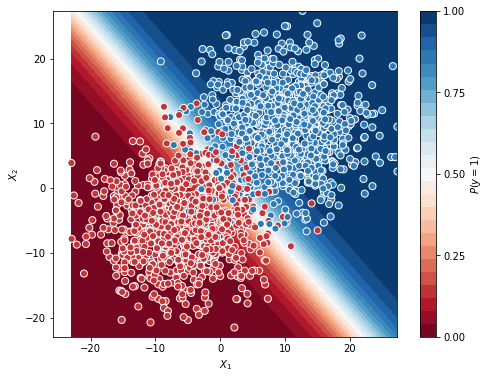

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import DataFrame

# Generación de un dataset de clasificación 2d de nubes de puntos.
X, y = make_blobs(n_samples=[1000,1000], centers=None, n_features=2, cluster_std=6, random_state=202)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()
# División de los datos en subconjuntos de entrenamiento/evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Ajuste del modelo.
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

xx, yy = np.mgrid[X.min(0)[0]:X.max(0)[0]:.01, X.min(0)[1]:X.max(0)[1]:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = LR.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(X.min(0)[1], X.max(0)[1]), ylim=(X.min(0)[0], X.max(0)[0]),
       xlabel="$X_1$", ylabel="$X_2$")

Recuerde tener mucho cuidado pues la regresión logística no es más que una regresión lineal, si los datos tienen relaciones no lineales será muy difícil para éste típo de algorítmo plantear una solución adecuada.

## 3.2.3 KNN
El algoritmo de k-NN es, sin lugar a dudas, el algoritmo más simple de ML. El modelo consiste solo en el almacenamiento en memoria de los datos de entrenamiento. Mediante este algoritmo, la clase de una instacia se predice al buscar dentro de los datos los vecinos más cercanos a la instacia.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


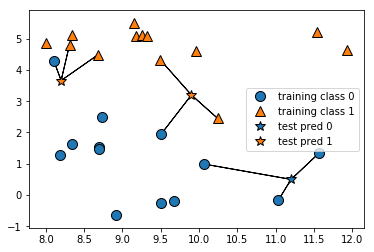

In [ ]:
mglearn.plots.plot_knn_classification(n_neighbors=3);

Entre más vecinos escojamos, la frontera se suaviza. Una frontera de desición suave. En otras palabras, el uso de pocos vecinos resulta en complejidades mayores de los modelos y el uso de muchos vecinos resulta en complejidades menores. En el caso extremo en que consideramos el número de vecinos igual al número de datos de la muestra, cada instancia nueva tendrá el mismo número de vecinos (toda la muestra) y la predicción será siempre la misma: la clase mas frecuente.

Veamos entonces si podemos encontrar una conexión entre la complejidad del modelo y una mayor generalización del mismo, como se señala en el párrafo anterior.


#### 3.2.4 Naive Bayes

Éstos modelos descansan sobre la teoría de estadística Bayesiana, en la cuál se describe la relación entre las probabilidades condicionales de cantidades estadísticas.

En clasificación estamos interesados en encontrar la probabilidad de un 'label' dados unos 'features', ésto puede escribirse como: $P(L~|~{\rm features})$.

Con el teorema de Bayes tenemos una forma explicita de calcular dichas cantidades:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$
Lo que necesitamos ahora es un modelo para calcular $P({\rm features}~|~L_i)$ para cada 'label'. Ése modelo es llamado modelo generativo (generative model) dado que el proceso con el que 'hipoteticamente' se generan los datos es aleatorio.

La especificación de dicho modelo es la tarea central del algoritmo, pero esa tarea es extremadamente compleja, por ello es necesario hacer algunas suposiciónes, de ahí el nombre de 'naive' (ingenuo)


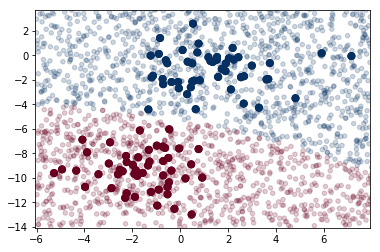

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs

X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

model = GaussianNB()
model.fit(X, y);

rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.2)
plt.axis(lim);

#### Cuando usar naive Bayes
Dados las asunciones de los clasificadores de Bayes sobre los datos, en general no tendrán un gran desempeño (comparados con modelos mucho más complicados), sin embargo:

Son extremadamente rápidos, tanto en entrenamiento como en predicción.
Entregan predicciones probabilisticas de manera simple (por diseño).
Son muy fáciles de implementar (a nivel de programación).
Tiene pocos hiper-parámetros.
Por tanto éstos clasificadores son uno de los primeros en implementarse como modelos de base.

Los clasificadores de Bayes tienden a ser muy buenos cuando:

Las asunciones naive realmente se cumplen en los datos (es un caso extraño en la realidad).
Para categirias bien diferenciadas en el espacio de carácteristicas.
Para datasets de alta dimensionalidad

## 3.2.5 Bosques aleatorios.

Llamamos método de ensamble a los métodos en los cuales se unen diferentes tipos de algorítmos o el mísmo algorítmo multiples veces con el fin de crear un predictor más robusto.

El método de bosques aleatorios no implementa un algorítmo de ML nuevo, como dijimos, en realidad es un ensamble de árboles de desición en el cual el entrenamiento se realiza mediante bootstraping y la desición final se toma con la moda (para clasificación) o la media (para regresión) de las predicciones de cada árbol.
![](https://colab.research.google.com/github/diplomado-bigdata-machinelearning-udea/Curso1/blob/master/s10/s10.ipynb#scrollTo=T6VXKRbK8dG9)


Existen varias ventajas de usar un bosque aleatorio:

Se usa bootstraping de los datos de entrenamiento, ésto hace que sea difícil sobreajustar los árboles, por el contrario ésto hace que cada árbol disminuya su varianza y al usar el metodo de "votación" se cancelan los sesgos. Los bosques aleatorios son excelentes en el bias-variance tradeoff.
Es un método muy robusto respecto al ruido en los datos.
Puede tenerse la importancia relativa de las carácterísticas, lo cual nos permite hacer selección de las mísmas para hacer reducción dimensional.
Puede entrenarse en paralelo cada árbol.
Eso si, tiene algunas desventajas:

Al ser un método de ensamble puede ser muy costoso computacionalmente, tanto para entrenamiento como para predicción.
Su interpretabilidad no es tan simple como la de un sólo árbol.

<p><img alt="Colaboratory logo" height="300px" src="https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso1/master/s10/desTreeAnimals.png" align="center" hspace="10px" vspace="0px"></p>
